In [26]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/paper-scissors-rock/data/ready/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0")

In [30]:
class_names

['empty', 'paper', 'rock', 'scissors']

In [49]:
dataset_sizes

{'train': 7061, 'val': 1958}

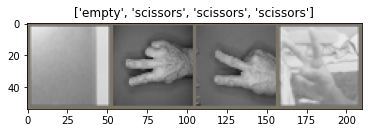

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
model_ft = models.resnet18(pretrained=True)
in_features = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(in_features,4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [46]:
model_ft.fc

Linear(in_features=512, out_features=4, bias=True)

In [47]:
num_ftrs

512

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.5412 Acc: 0.8322
val Loss: 0.3111 Acc: 0.9035

Epoch 1/14
----------
train Loss: 0.1500 Acc: 0.9618
val Loss: 0.3296 Acc: 0.9122

Epoch 2/14
----------
train Loss: 0.1107 Acc: 0.9752
val Loss: 0.5447 Acc: 0.8698

Epoch 3/14
----------
train Loss: 0.0868 Acc: 0.9803
val Loss: 0.2716 Acc: 0.9162

Epoch 4/14
----------
train Loss: 0.0570 Acc: 0.9854
val Loss: 0.2481 Acc: 0.9300

Epoch 5/14
----------
train Loss: 0.0507 Acc: 0.9882
val Loss: 0.5002 Acc: 0.8606

Epoch 6/14
----------
train Loss: 0.0396 Acc: 0.9915
val Loss: 0.2816 Acc: 0.9116

Epoch 7/14
----------
train Loss: 0.0269 Acc: 0.9931
val Loss: 0.2360 Acc: 0.9259

Epoch 8/14
----------
train Loss: 0.0214 Acc: 0.9941
val Loss: 0.2480 Acc: 0.9127

Epoch 9/14
----------
train Loss: 0.0226 Acc: 0.9939
val Loss: 0.2246 Acc: 0.9178

Epoch 10/14
----------
train Loss: 0.0127 Acc: 0.9969
val Loss: 0.2485 Acc: 0.9091

Epoch 11/14
----------
train Loss: 0.0189 Acc: 0.9959
val Loss: 0.2929 Acc: 0.9132

Ep

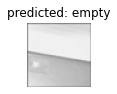

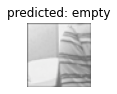

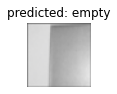

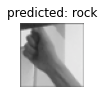

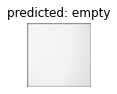

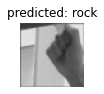

In [9]:
visualize_model(model_ft)

In [15]:
import torch
import torchvision.models as models
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/paper-scissors-rock/model/ResNet_weights.pth')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model = torch.load('/content/drive/MyDrive/paper-scissors-rock/model/ResNet_weights.pth')

In [18]:
model_ft.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 5.4155e-03,  4.6325e-03,  1.2983e-02,  ...,  6.4982e-02,
                          3.5871e-02,  7.8021e-03],
                        [ 2.2876e-02,  2.4080e-02, -9.4837e-02,  ..., -2.4903e-01,
                         -1.0407e-01,  2.2502e-02],
                        [ 8.0862e-03,  7.2822e-02,  3.1178e-01,  ...,  5.4115e-01,
                          2.7714e-01,  7.6962e-02],
                        ...,
                        [-1.8106e-02,  1.8328e-02,  7.0205e-02,  ..., -3.3865e-01,
                         -4.2285e-01, -2.5421e-01],
                        [ 4.3126e-02,  5.4348e-02,  6.9996e-02,  ...,  4.1560e-01,
                          4.0152e-01,  1.7019e-01],
                        [-9.9642e-04,  7.5493e-03, -9.7798e-03,  ..., -1.4278e-01,
                         -6.5340e-02,  9.7637e-03]],
              
                       [[ 5.4284e-03, -1.6224e-02, -2.0131e-02,  ...,  4.0582e-02,
                          2.0691

In [20]:
!apt install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [1]:
%cd /content/drive/MyDrive/paper-scissors-rock

/content/drive/MyDrive/paper-scissors-rock


In [2]:
!pwd

/content/drive/MyDrive/paper-scissors-rock


In [8]:
!git init

Initialized empty Git repository in /content/drive/MyDrive/paper-scissors-rock/.git/


In [9]:
!git remote add origin 'https://github.com/mmenuu/SAIG-Paper-Scissors-Rock.git'

In [ ]:
!git add .


In [ ]:
!git commit -m 'ResNet'

In [ ]:
!git push